# Profast Data Analysis

This notebook is divided into two main sections:
1. [Data and Correlation Analysis and Preprocessing](http://localhost:8888/notebooks/tasrif/test_scripts/ProfastDataAnalysis.ipynb#1.-Data-and-Correlation-Analysis-and-Preprocessing)
2. [Machine Learning for CGM Prediction](http://localhost:8888/notebooks/tasrif/test_scripts/ProfastDataAnalysis.ipynb#2---Machine-Learning-for-CGM-Prediction)

## 1. Data and Correlation Analysis and Preprocessing

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from dataprep.eda import create_report
import seaborn as sns
import matplotlib.pyplot as plt

from tasrif.data_readers.siha_dataset import \
    SihaSleepDataset, \
    SihaStepsIntradayDataset, \
    SihaCaloriesIntradayDataset, \
    SihaDistanceIntradayDataset, \
    SihaHeartRateIntradayDataset, \
    SihaVeryActiveMinutesDataset, \
    SihaLightlyActiveMinutesDataset, \
    SihaSedentaryMinutesDataset, \
    SihaModeratelyActiveMinutesDataset, \
    SihaTimeInHeartRateZonesDataset, \
    SihaStepsDataset, \
    SihaCaloriesDataset, \
    SihaDistanceDataset, \
    SihaCgmDataset, \
    SihaEmrDataset, \
    SihaSleepIntradayDataset, \
    SihaCompositeDataset



from tasrif.processing_pipeline import ProcessingPipeline
from tasrif.processing_pipeline.pandas import ResetIndexOperator
from tasrif.processing_pipeline.pandas import DropFeaturesOperator
from tasrif.processing_pipeline.pandas import DropDuplicatesOperator
from tasrif.processing_pipeline.pandas import DropNAOperator
from tasrif.processing_pipeline.pandas import RenameOperator
from tasrif.processing_pipeline.pandas import GroupbyOperator
from tasrif.processing_pipeline.pandas import SumOperator
from tasrif.processing_pipeline.pandas import CorrOperator
from tasrif.processing_pipeline.pandas import MeanOperator
from tasrif.processing_pipeline.pandas import SetIndexOperator
from tasrif.processing_pipeline.pandas import ApplyOperator
from tasrif.processing_pipeline.pandas import AsTypeOperator
from tasrif.processing_pipeline.pandas import PivotOperator
from tasrif.processing_pipeline.pandas import RollingOperator
from tasrif.processing_pipeline.pandas import MergeOperator
from tasrif.processing_pipeline.custom import ResampleOperator
from tasrif.processing_pipeline.custom import SetFeaturesValueOperator
from tasrif.processing_pipeline.custom import CreateFeatureOperator
from tasrif.processing_pipeline.custom import AggregateOperator



NumExpr defaulting to 8 threads.


Change the path below to where the data actually is

In [3]:
profast_datapath='../../data/profast2020/'
profast_datapath='../../../'

Below, we defined a set of helper functions for the analysis.
Some of them could be eventually integrated back to Tasrif

In [3]:
def get_participant(df, pid):
    return df[df["patientID"] == pid]

def corr_per_day(df):
    pipeline = []
    pipeline.append(GroupbyOperator(by=pd.Grouper(key='time',freq='D'), 
                                    select=["Calories", "mets", "Steps", "Distance", "CGM"]))
    pipeline.append(CorrOperator())
    
    pipeline = ProcessingPipeline(pipeline)
    df = pipeline.process(df)[0]
    return df

def get_data_day(df, month, day, time_col="time"):
    return df[(df[time_col].dt.month == month) & (df[time_col].dt.day == day)]


def agg_per_day(df, metric, operation, outputcol_name=None, pid_col="patientID", time_col="time", 
                remove_zero_steps=False):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0]
    else:
        df_tmp = df.copy()

    # Get aggregated number of [steps, calories, ...] in a day
    
    if(operation == 'mean'):
        metric_per_day = ProcessingPipeline([
                            GroupbyOperator(by=[pid_col, pd.Grouper(key=time_col,freq='D')], select=metric),
                            MeanOperator()
                        ]).process(df_tmp)[0]
    else:
        metric_per_day = ProcessingPipeline([
                            GroupbyOperator(by=[pid_col, pd.Grouper(key=time_col,freq='D')], select=metric),
                            SumOperator()
                        ]).process(df_tmp)[0]
    
    if outputcol_name is not None:
        metric_per_day.name = outputcol_name
    return metric_per_day

def sum_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "sum", outputcol_name, pid_col, time_col, remove_zero_steps)

def mean_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "mean", outputcol_name, pid_col, time_col, remove_zero_steps)



### First Goal: Combining intra day data

In [1]:
from tasrif.data_readers.siha_dataset import SihaCompositeDataset

composite = SihaCompositeDataset(profast_folder='/mnt/c/Development/projects/siha')

before_ramdan, during_ramadan, df_intra = composite.processed_df
before_ramdan, during_ramadan, df_intra = before_ramdan[0], during_ramadan[0], df_intra[0]

Remaining number of participants: 14


<AxesSubplot:xlabel='time'>

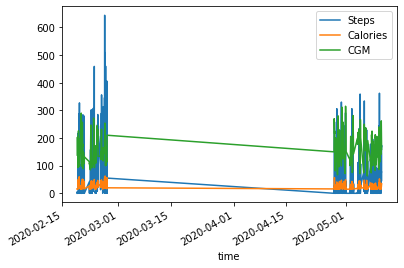

In [5]:
d = get_participant(df_intra, 39)
d.plot(x="time", y=["Steps", "Calories", "CGM"])

  0%|          | 0/1480 [00:00<?, ?it/s]

DataPrep Report
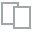
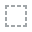
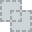
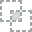
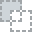
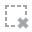
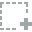
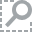
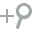
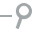
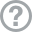
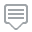
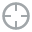
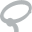
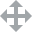
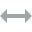
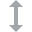
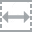
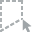
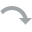
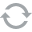
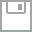
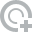
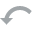
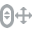
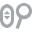
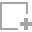
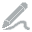
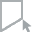
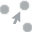
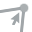
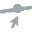

In [6]:
create_report(before_ramdan)

  0%|          | 0/1480 [00:00<?, ?it/s]

DataPrep Report
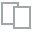
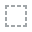
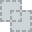
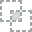
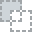
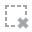
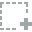
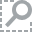
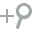
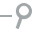
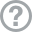
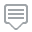
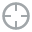
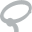
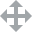
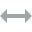
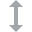
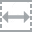
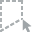
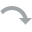
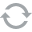
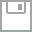
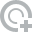
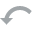
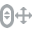
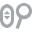
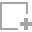
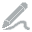
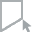
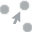
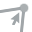
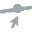

In [7]:
create_report(during_ramadan)

In [8]:
df_intra

patientID                time  HeartRate  level   mets   Calories  \
1277          32 2020-02-17 10:30:00  88.266670    1.0  616.0  91.580719   
1278          32 2020-02-17 10:45:00  75.933334    1.0  234.0  34.788780   
1279          32 2020-02-17 11:00:00  75.066666    1.0  440.0  65.414803   
1280          32 2020-02-17 11:15:00  76.599998    1.0  282.0  41.924938   
1281          32 2020-02-17 11:30:00  83.466667    1.0  339.0  50.399132   
...          ...                 ...        ...    ...    ...        ...   
48604         85 2020-05-23 22:45:00  77.666664    0.0  154.0  18.221279   
48605         85 2020-05-23 23:00:00  74.866669    0.0  174.0  20.587681   
48606         85 2020-05-23 23:15:00  96.666664    1.0  393.0  46.499760   
48607         85 2020-05-23 23:30:00  77.866669    0.0  155.0  18.339600   
48608         85 2020-05-23 23:45:00  83.266670    1.0  235.0  27.805201   

       Steps  Distance    CGM  Ramadan  hypo  hyper  
1277   408.0  0.200765  128.0        0     0      0  
1278    22.0  0.010750  128.5        0     0      0  
1279   309.0  0.151863  171.0        0     0      0  
1280   106.0  0.052071  176.0        0     0      0  
1281   170.0  0.083574  172.0        0     0      0  
...      ...       ...    ...      ...   ...    ...  
48604    0.0  0.000000  121.0        1     0      0  
48605   16.0  0.007394  120.0        1     0      0  
48606  200.0  0.092522  113.5        1     0      0  
48607    0.0  0.000000  121.0        1     0      0  
48608   61.0  0.028148  124.0        1     0      0  

[37023 rows x 12 columns]

## Correlation Analysis

In [15]:
composite.Default.is_hypo(3)

1

### Correlations at user day

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-Steps'>

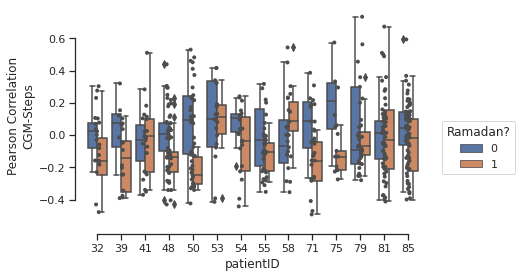

In [35]:
composite.boxplot_correlation(df_intra, 'Steps')

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-Calories'>

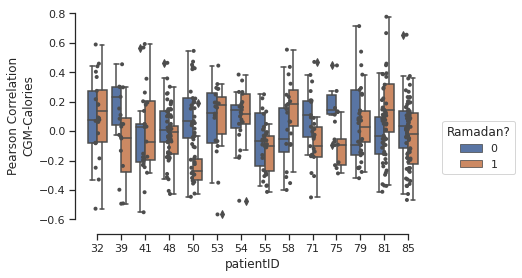

In [3]:
composite.boxplot_correlation(df_intra, "Calories")

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-HeartRate'>

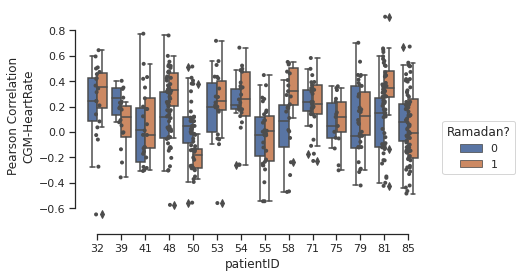

In [4]:
composite.boxplot_correlation(df_intra, "HeartRate")

### Correlations at user level

Next, our aim is to create correlation at user level. For that, we first aggregate the data at day level (e.g., average number of steps in a day) and then average the data at user level (i.e., average number of steps per day for participant X).

For that, we will first load the EMR data and do a few data cleaning steps.

#### Load EMR data, clean and pivot it

In [3]:
emr = SihaEmrDataset(folder='/mnt/c/Development/projects/siha')
df_emr, drugs_per_patient = emr.processed_df
df_emr, drugs_per_patient = df_emr[0], drugs_per_patient[0]

In [ ]:
# Tried to normalize the drug names
drugs = set([])


# Add to drugs set
ApplyOperator(lambda l: [drugs.add(x) for x in l]).process(drugs_per_patient)[0]

print("%d different drugs: %s" % (len(drugs), drugs))

for d in drugs:
    df_emr = CreateFeatureOperator(
                feature_name=d, 
                feature_creator=lambda df: d in df['Diabetes Medication']
             ).process(df_emr)[0]
    
df_emr.head()

In [ ]:
df_agg = pd.concat([mean_per_day(df_intra, "Steps", "MeanSteps", remove_zero_steps=True),
                      sum_per_day(df_intra, "Steps", "SumSteps", remove_zero_steps=True),
                      mean_per_day(df_intra, "Calories", remove_zero_steps=True),
                      sum_per_day(df_intra, "Calories", "SumCalories", remove_zero_steps=True),
                      mean_per_day(df_intra, "Distance", remove_zero_steps=True),
                      sum_per_day(df_intra, "Distance", "SumDistance", remove_zero_steps=True),
                      mean_per_day(df_intra, "mets", remove_zero_steps=True),
                      mean_per_day(df_intra, "HeartRate", remove_zero_steps=True),
                      mean_per_day(df_intra, "CGM", remove_zero_steps=True),
                      mean_per_day(df_intra, "hypo", "AvgHypo", remove_zero_steps=True),
                      sum_per_day(df_intra, "hypo", "TotalHypo", remove_zero_steps=True),
                      mean_per_day(df_intra, "hyper", "AvgHyper", remove_zero_steps=True),
                      sum_per_day(df_intra, "hyper", "TotalHyper", remove_zero_steps=True),
                      mean_per_day(df_intra, "Ramadan", "IsRamadan", remove_zero_steps=True),
                      ], axis=1)

pipeline = ProcessingPipeline([
    ResetIndexOperator(),
    GroupbyOperator(by='patientID'),
    MeanOperator(),
])

df_means = pipeline.process(df_agg)[0]
df_means

In [ ]:
df_merged = MergeOperator(left_index=True, right_index=True).process(df_means, df_emr, df_steps, df_distance)
df_merged.head()

In [ ]:
for d in drugs:
    df_drug = df_merged[df_merged[d] == True]
    print("People in the final dataset that took drug %s: %d" % (d, df_drug.shape[0]))

We are now able to compare the correlation between any number of groups.
For example, below we verify that the correlation between average CGM and HeartRate was strong for participants taking the combo of Metformin and Sitagliptin, while it was the opposite for participants not taking these drugs. 

⭐️⭐️⭐️ <b> TODO: we need to know what kind of medicament combination is important! </b> ⭐️⭐️⭐️

In [ ]:
# Compared the data for the 8 people with combo ["Metformin", "Sitagliptin"] against without (4)
df_grp1 = df_merged[((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]
df_grp2 = df_merged[~((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]

print("Corr CGM-HeartRate Grp1: %.3f, Grp2: %.3f" % (df_grp1.corr()["CGM"]["HeartRate"],
                                                     df_grp2.corr()["CGM"]["HeartRate"]))

Before moving to the next section, we save a postprocessed dataframe to disk in order to speed up futher ML pipelines.

In [ ]:
profast_ml = os.path.join(profast_datapath, "preprocessed")
if not os.path.exists(profast_ml):
    os.mkdir(profast_ml)

df_intra.to_csv(os.path.join(profast_ml, "data.csv.gz"), index=False)

## 2 - Machine Learning for CGM Prediction

This second part of this notebook used the preprocessed data from profast 2020 for CGM prediction.
Note that we can move this section elsewhere without problem if this notebook becomes too extense.
For that, we start by loading the preprocessed data.

In [ ]:
df = pd.read_csv(os.path.join(profast_ml, "data.csv.gz"))
df["time"] = pd.to_datetime(df["time"])
df.head()

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, KFold, GroupKFold

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from pycaret.regression import *

Next, following the idea of [this tensorflow tutorial on time_series analysis](https://www.tensorflow.org/tutorials/structured_data/time_series), we transformed time of the day into a continous sin/cos cyclic feature.

In [ ]:
def convert_time_sin_cos(df, datetime_col):

    day = 24*60*60
    
    pipeline = ProcessingPipeline([
        ApplyOperator(lambda x: x.timestamp()),
        AsTypeOperator(int)
    ])
    
    ts = pipeline.process(df[datetime_col])[0]
    
    
    
    day_sin = np.sin(ts * (2 * np.pi / day))
    day_cos = np.cos(ts * (2 * np.pi / day))
    
    return day_sin, day_cos
    
    
df["time_sin"], df["time_cos"] = convert_time_sin_cos(df, "time")

df[df["patientID"] == 32]["time_sin"].plot()


In [ ]:
def generate_slide_wins(df_in, start_seq=0, winsize="1h15t", time_col="time", 
                        label_col="CGM", pid_col="patientID"):
    """
    From a timeseries of ONE participant, this function generates two dataframes: <time_series_features>, <labels>
    The first dataframe can be used with tsfresh later on, while the second has all the labels that we want to predict.

    Notice that the default winsize is 1h and 15 minutres (`1h15t`).
    We used the first hour to extract the features and the 15 min only to collect the ground_truth labels.

    """
    seq_id = start_seq
    transformed_df = []
    list_of_indices = []
    labels = []
    label_times = []

    pid = df_in[pid_col].unique()
    if len(pid) > 1:
        print("ERROR: We should have only one pid here. Aborting")
        return
    pid = pid[0]
    
    df = df_in.reset_index(drop=True).copy()
    
    # The following code will construct a rolling win that could be based on either time or #win
    # This will feed list_of_indexes with the sub-win indices that will be used in the next for loop    
    pipeline = ProcessingPipeline([
        ResetIndexOperator(),
        RollingOperator(winsize, select='index', on=time_col, center=False),
        ApplyOperator((lambda x: list_of_indices.append(x.tolist()) or 0))
    ])
    
    pipeline.process(df)[0]
    
    # Time-based win might be smaller than the expected size. We fix it by comparing the size of each
    # value in the list_of_indices with the size of the last element
    max_size = len(list_of_indices[-1])

    
    for idx in list_of_indices:
        if len(idx) != max_size:
            continue

        labels.append(df.loc[idx].iloc[-1][label_col])
        label_times.append(df.loc[idx].iloc[-1][time_col])
        
        tmp_df = df.loc[idx[0:-1]].copy()
        tmp_df["seq_id"] = seq_id
        seq_id += 1

        del tmp_df[pid_col]
        
        transformed_df.append(tmp_df)

    labels = pd.Series(labels)
    labels.name = "ground_truth"
    
    label_times = pd.Series(label_times)
    label_times.name = "gt_time"
    
    transformed_df = pd.concat(transformed_df).reset_index(drop=True)
    pid = pd.Series([pid] * labels.shape[0])
    pid.name = "pid"
    
    return seq_id, transformed_df, labels, label_times, pid

In [ ]:
generate_slide_wins(df.head(22), start_seq=0, winsize="3h15t")

Different winsizes will render different number of epochs. 
For example, if we do not have continous CGM recorded for 5 hours, we cannot generate features with a winsize bigger than 4:45min.


In [ ]:
winsizes = ["%dh%02dt" % (hour, minute) for hour in range(1, 6) for minute in [0, 15, 45] ]

df_result = []
for winsize in winsizes:
    df_timeseries = []
    row = {}
    last_seq = 0
    for pid in tqdm(df["patientID"].unique()):
        df_tmp = df[df["patientID"] == pid]
        last_seq, df_ts_tmp, _, _, _ = generate_slide_wins(df_tmp[["patientID", "time", "CGM"]], start_seq=last_seq, winsize=winsize)
        df_timeseries.append(df_ts_tmp)
    
    row["winsize"] = winsize
    row["total_number_examples"] = last_seq
    df_result.append(row)
    
pd.DataFrame(df_result).set_index("winsize").plot()

In [ ]:
signals = ["time", "patientID", "time_sin", "time_cos", 
           "HeartRate", "mets", "Calories", "Steps", "Distance", "CGM"]

winsize = "3h15t"

df_labels = []
df_label_time = []
df_timeseries = []
df_pids = []

last_seq_id = 0

for pid in tqdm(df["patientID"].unique()):

    df_tmp = df[df["patientID"] == pid]

    last_seq_id, df_ts_tmp, df_label_tmp, df_label_time_tmp, df_pid = generate_slide_wins(df_tmp[signals],
                                                                                          start_seq=last_seq_id,
                                                                                          winsize=winsize)
    df_timeseries.append(df_ts_tmp)
    df_labels.append(df_label_tmp)
    df_label_time.append(df_label_time_tmp)
    df_pids.append(df_pid)
    

df_labels = pd.concat(df_labels).reset_index(drop=True)
df_label_time = pd.concat(df_label_time).reset_index(drop=True)
df_timeseries = pd.concat(df_timeseries).reset_index(drop=True)

df_pids = pd.concat(df_pids).reset_index(drop=True)
df_pids.name = "pid"

In [ ]:
if os.path.exists(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize))):
    extracted_feature = pd.read_csv(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize)))
else:
    extracted_features = extract_features(df_timeseries, column_id="seq_id", column_sort="time")
    extracted_features.to_csv(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize)), index=False)

In [ ]:
if os.path.exists(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize))):
    features_filtered = pd.read_csv(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize)))
else:
    impute(extracted_features)
    features_filtered = extract_relevant_features(df_timeseries, df_labels, column_id='seq_id', column_sort='time')
    features_filtered.to_csv(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize)), index=False)

In [ ]:
assert features_filtered.shape[0] == df_labels.shape[0]

In [ ]:
data = pd.concat([df_pids, df_labels, features_filtered], axis=1)
data = MergeOperator(left_on="pid", right_index=True).process(data, df_emr)[0]

print("Note that there were many NAN in the ERM files.")
print("If we dropall NAN, we go from %d rows to %d (i.e., from %d to %d participants)" % (data.shape[0], 
                                                                                          data.dropna().shape[0],
                                                                                          data["pid"].unique().shape[0],
                                                                                          data.dropna()["pid"].unique().shape[0]))

print("So, lets dropping NAs...")

data = DropNAOperator().process(data)[0]


In [ ]:
# TODO: add other time relateted features (isRamadan, day_sin, day_cos)

Next we map all features to a dictionary called feature_mapping. 
Later, this will help us to build models using different feature sets.
Example ``model(data[feature_mapping["Steps"]])`` would create a model only using "Steps".

In [ ]:
feature_mapping = {}
mapped_feature = set([])

for feature in signals:
    for k in data.keys():
        if k.startswith(feature):
            if feature not in feature_mapping:
                feature_mapping[feature] = []
            feature_mapping[feature].append(k)            
            mapped_feature.add(k)

feature_mapping["other"] = []
for k in data.keys():
    if k not in mapped_feature and k not in ['pid', 'ground_truth']:
        feature_mapping["other"].append(k)
            
feature_mapping

In [ ]:
df_emr.keys() # ["Cholesterol"]# astype(np.float)

In [ ]:
data[["pid", "ground_truth"] + feature_mapping["Steps"]].head(5)

In [ ]:
def map_id_fold(all_ids, n, pid_col="pid"):
    
    pids = all_ids[pid_col].unique().ravel()
    if n < 0:
        n = len(pids)
    
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    mapping = []
    for i, (_, test) in enumerate(kf.split(pids)):
        for pid_index in test:
            mapping.append({'fold': i, pid_col: pids[pid_index]})

    return pd.DataFrame(mapping)

In [ ]:
df_folds = map_id_fold(data, -1)
df_folds.head(10)

In [ ]:
data = MergeOperator().process(df_folds, data)[0]
data.head()

In [ ]:
def get_cols_by_featureset(data, featset, feature_mapping):
    acc_feats = []
    for f in featset:
        acc_feats.extend(feature_mapping[f])
        
    return ["pid", "ground_truth", "fold"] + acc_feats


In [ ]:
feature_sets = [['mets', 'Calories', 'Steps', 'Distance', 'CGM'],
               ['mets', 'Calories', 'Steps', 'Distance'], 
               ['mets', 'Calories', 'Steps', 'Distance', 'CGM', 'other'],
               ['mets', 'Calories', 'Steps', 'Distance', 'other'], 
              ]

results = []
for featset in feature_sets:
    train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
    last_fold = train_data["fold"].max()
    test_data = train_data[train_data["fold"] == last_fold]
    train_data = train_data[train_data["fold"] != last_fold]
    
    cv = GroupKFold()
    
    experiment = setup(data = train_data, test_data = test_data,
                       target='ground_truth', session_id=42, silent=True,
                       fold_strategy = cv, fold_groups = 'fold',
                       fold = last_fold-1,
                       ignore_features = ["pid"]
                      )
    
    best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
    create_model(best_model)
    result = pull()
    
    row = {}
    row["featset"] = featset
    row["r2"] = result.loc["Mean"]["R2"]
    row["rmse"] = result.loc["Mean"]["RMSE"]
    row["name"] = best_model
    results.append(row)
    
pd.DataFrame(results)